In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.linalg import eigh
from sklearn.decomposition import PCA
import random
import time

main_path = '/content/drive/MyDrive/Colab Notebooks/Enhance Fisher face/'  ## path to current directory

#### Read images and resize them to 32*32 images and then creat vectors for any image

In [45]:
def img2vec(data_name):
    """ Read images and conver them to vectors """
    data_path = main_path + 'data/' + data_name + '/'
    data =[]
    labels = []
    file_names = listdir(data_path)
    # random.shuffle(file_names)
    for img_name in file_names:
        if img_name[img_name.rfind('.')+1:] in ['txt', 'gif']:
            continue
        img = Image.open(data_path+img_name)
        new_size = (32, 32)  ## Paper said that images are resized to 32*32 
        img = img.resize(new_size)
        img = np.asarray(img)
        img_vec = np.resize(img, img.shape[0]*img.shape[1])  ## resize img to vector
        data.append(img_vec)
        label = img_name[:img_name.find('.')]  ## use first part of file name as label (name for any person)
        labels.append(label)
    return np.array(data), np.array(labels)
img_vectors, labels = img2vec('yalefaces')
print('shape of data: ' + str(img_vectors.shape))

shape of data: (164, 1024)


#### Split train and test data

In [4]:
def split_train_test(data, labels, num_train):
    """ 
    Get data and split them to train and test accourding to number of training img.
    Paper use 3, 6 and 9 image of any person as trainig and other for testing. 
    This number is 'num_train' input parameter.
    """
    train_index = []
    train_per_label = {label:0 for label in set(labels)}
    for i in range(data.shape[0]):
        if train_per_label[labels[i]] < num_train:
            train_index.append(1)
            train_per_label[labels[i]] += 1
        else: 
            train_index.append(0)
    train_index = np.array(train_index)
    train_data = data[train_index==1]
    test_data = data[train_index==0]
    train_labels = labels[train_index==1]
    test_labels = labels[train_index==0]
    return train_data, test_data, train_labels, test_labels

train_data, test_data, train_labels, test_labels = split_train_test(img_vectors, labels, 3)
print('shape of train data: ' + str(train_data.shape))
print('shape of test data: ' + str(test_data.shape))

shape of train data: (45, 1024)
shape of test data: (119, 1024)


#### Create adjacency graph

In [5]:
def get_adj_graph(data, labels):
    """ Create adjacency graph based on formula of paper """
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(data, [0 for _ in range(data.shape[0])])
    nearest_of_data = knn.kneighbors(data, n_neighbors=4, return_distance=False)
    adj_graph = np.zeros((data.shape[0], data.shape[0]))
    for i in range(data.shape[0]):
        vec1 = data[i]
        for j in range(data.shape[0]):
            if i!=j and (i in nearest_of_data[j] or j in nearest_of_data[i]) and labels[i]==labels[j]:
                vec2 = data[j]
                dist = np.linalg.norm(vec1-vec2)
                if dist != 0:
                    t = 10
                    adj_graph[i][j] = np.exp(-t/(dist**2))
    return adj_graph
adj_graph = get_adj_graph(train_data, train_labels)
print('shape of adjacency graph: ' + str(adj_graph.shape))

shape of adjacency graph: (45, 45)


#### Create Sw, Sb, Sd scatter matrixes

In [6]:
def get_mean_of_classes(data, labels):
    """ Calculate mean vector for any class """
    mean_per_class = {}
    size_of_classes = {}
    for i in range(data.shape[0]):
        if labels[i] in mean_per_class.keys():
            mean_per_class[labels[i]] += data[i]
            size_of_classes[labels[i]] += 1
        else:
            mean_per_class[labels[i]] = data[i]
            size_of_classes[labels[i]] = 1
    for key, val in mean_per_class.items():
        mean_per_class[key] = val/size_of_classes[key]
    return mean_per_class, size_of_classes

def get_Sw(data, labels, mean_per_class):
    """ Calculate withen scatter matrix """
    S_w = np.zeros((data.shape[1], data.shape[1]))
    for i in range(data.shape[0]):
        sub_vec = (data[i] - mean_per_class[labels[i]]).reshape((data.shape[1], 1))
        S_w = S_w + (sub_vec @ sub_vec.T)
    S_w = S_w/data.shape[0]
    return S_w

def get_Sb(data, labels, mean_per_class, size_of_classes, mean_vec):
    """ Calculate between scatter matrix """
    S_b = np.zeros((data.shape[1], data.shape[1]))
    for label, class_mean in mean_per_class.items():
        sub_mean = (class_mean - mean_vec).reshape((data.shape[1], 1))
        S_b = S_b + (sub_mean @ sub_mean.T)*size_of_classes[label]
    S_b = S_b/data.shape[0]
    return S_b

def get_Sd(data, adj_graph):
    """ Calculate variability scatter matrix that is proposed in paper """
    F_matrix = np.zeros(adj_graph.shape)
    for i in range(F_matrix.shape[0]):
        F_matrix[i][i] = adj_graph[i].sum()
    S_d = data.T @ (F_matrix - adj_graph) @ data
    S_d = S_d/data.shape[0]
    return S_d

def get_scatter_matrixes(data, labels, adj_graph):
    """ Use above functions to get scatter matixes """
    mean_vec = data.mean(axis=0)
    mean_per_class, size_of_classes = get_mean_of_classes(data, labels)
    S_w = get_Sw(data, labels, mean_per_class)
    S_b = get_Sb(data, labels, mean_per_class, size_of_classes, mean_vec)
    S_d = get_Sd(data, adj_graph)
    return S_w, S_b, S_d

S_w, S_b, S_d = get_scatter_matrixes(train_data, train_labels, adj_graph)
print('mean vector per classes is calculated.')
print('shape of Sw: ' + str(S_w.shape))
print('shape of Sb: ' + str(S_b.shape))
print('shape of Sd: ' + str(S_d.shape))

mean vector per classes is calculated.
shape of Sw: (1024, 1024)
shape of Sb: (1024, 1024)
shape of Sd: (1024, 1024)


#### Use PCA to decompose dimention of data

In [7]:
def decompose_scatter_matrixes(data, S_w, S_b, S_d, PCA_ratio):
    """ Decompose scatter matrixes using PCA """
    pca = PCA(n_components = PCA_ratio)
    decomposed_img_vecs = pca.fit_transform(data)
    W_pca = pca.components_.T
    decomposed_S_w = W_pca.T @ S_w @ W_pca
    decomposed_S_b = W_pca.T @ S_b @ W_pca
    decomposed_S_d = W_pca.T @ S_d @ W_pca
    return decomposed_img_vecs, decomposed_S_w, decomposed_S_b, decomposed_S_d, W_pca

decomposed_img_vecs, decomposed_S_w, decomposed_S_b, decomposed_S_d, W_pca = decompose_scatter_matrixes(train_data, S_w, S_b, S_d, 0.96)
print('shape of W_pca:' + str(W_pca.shape))
print('shape of decomposed image vectors: ' + str(decomposed_img_vecs.shape))
print('shape of decomposed Sw: ' + str(decomposed_S_w.shape))
print('shape of decomposed Sb: ' + str(decomposed_S_b.shape))
print('shape of decomposed Sd: ' + str(decomposed_S_d.shape))

shape of W_pca:(1024, 28)
shape of decomposed image vectors: (45, 28)
shape of decomposed Sw: (28, 28)
shape of decomposed Sb: (28, 28)
shape of decomposed Sd: (28, 28)


#### Calculate generalized eigen vectors

In [8]:
def get_generalized_eigens(S_w, S_b, S_d, a, n_features):
    """ Calculate eigen vectors of (a*Sb + (1-a)Sd)v = λ*Sw*v """
    A = a*S_b + (1-a)*S_d
    B = S_w
    eigvals, eigvecs = eigh(A, B, eigvals_only=False)
    W_E = eigvecs[:,:n_features]
    return W_E
W_E = get_generalized_eigens(decomposed_S_w, decomposed_S_b, decomposed_S_d, 0.9, 14)
print('shape of eigen vectors: '+ str(W_E.shape))

shape of eigen vectors: (28, 14)


#### Project data to new space

In [9]:
def project_data(data, W_pca, W_E):
    """ Project data to new space """
    W = W_pca @ W_E
    projected_data = W.T @ data
    return projected_data.T
projected_train_vectors = project_data(train_data.T, W_pca, W_E)
print('shape of projected imgage vectors: '+ str(projected_train_vectors.shape))

shape of projected imgage vectors: (45, 14)


#### Evaluation accuracy of this method

In [10]:
def get_classifier(train_data, train_labels):
    """ Use nearest neighbour as classifier (as paper use) """
    classifier = KNeighborsClassifier(n_neighbors = 1)
    classifier.fit(train_data, train_labels)
    return classifier

def evaluate(classifier, test_data, test_labels, W_pca, W_E):
    """ Evaluate method """
    projected_test_vectors = project_data(test_data.T, W_pca, W_E) ## project test data to new space
    predicted_labels = classifier.predict(projected_test_vectors)
    accuracy = accuracy_score(test_labels, predicted_labels)
    return accuracy

classifier = get_classifier(projected_train_vectors, train_labels)
accuracy = evaluate(classifier, test_data, test_labels, W_pca, W_E)
print('accuracy: ' + str(accuracy))

accuracy: 0.8067226890756303


## Run all parts for different train and test data

#### Paper used 3, 6 and 9 images per person as trainig and other for testing and then compared results. Also it use different dimentions of features for any of these.

In [23]:
all_num_train = [3, 6, 9]
all_num_features = [10, 12, 12]
for i in range(3):
    num_train = all_num_train[i]
    num_features = all_num_features[i]
    img_vectors, labels = img2vec('yalefaces')
    train_data, test_data, train_labels, test_labels = split_train_test(img_vectors, labels, num_train)
    adj_graph = get_adj_graph(train_data, train_labels)
    S_w, S_b, S_d = get_scatter_matrixes(train_data, train_labels, adj_graph)
    decomposed_img_vecs, decomposed_S_w, decomposed_S_b, decomposed_S_d, W_pca = decompose_scatter_matrixes(train_data, S_w, S_b, S_d, 0.96)
    W_E = get_generalized_eigens(decomposed_S_w, decomposed_S_b, decomposed_S_d, 0.9, num_features)
    projected_train_vectors = project_data(train_data.T, W_pca, W_E)
    classifier = get_classifier(projected_train_vectors, train_labels)
    accuracy = evaluate(classifier, test_data, test_labels, W_pca, W_E)
    print('{} images are selected for training:'.format(num_train))
    print('\t accuracy : ' + str(accuracy))

3 images are selected for training:
	 accuracy : 0.8235294117647058
6 images are selected for training:
	 accuracy : 0.8918918918918919
9 images are selected for training:
	 accuracy : 0.9655172413793104


#### Recognition accuracy vs. number project vectors

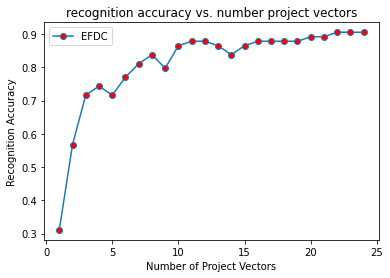

In [12]:
def plot_acc_per_dim(acc_per_dim, x_label, y_label, title):
    plt.plot(list(acc_per_dim.keys()), list(acc_per_dim.values()), marker='o', markerfacecolor='red', label = "EFDC")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

num_train = 6  ## Paper use 6 image per person for training in this expriment
img_vectors, labels = img2vec('yalefaces')
train_data, test_data, train_labels, test_labels = split_train_test(img_vectors, labels, num_train)
adj_graph = get_adj_graph(train_data, train_labels)
S_w, S_b, S_d = get_scatter_matrixes(train_data, train_labels, adj_graph)
decomposed_img_vecs, decomposed_S_w, decomposed_S_b, decomposed_S_d, W_pca = decompose_scatter_matrixes(train_data, S_w, S_b, S_d, 0.9)

acc_per_dim = {}
for dim in range(1, 25):
    W_E = get_generalized_eigens(decomposed_S_w, decomposed_S_b, decomposed_S_d, 0.9, dim)
    projected_train_vectors = project_data(train_data.T, W_pca, W_E)
    classifier = get_classifier(projected_train_vectors, train_labels)
    accuracy = evaluate(classifier, test_data, test_labels, W_pca, W_E)
    acc_per_dim[dim] = accuracy
    
plot_acc_per_dim(acc_per_dim, 'Number of Project Vectors', 'Recognition Accuracy', 'recognition accuracy vs. number project vectors')

#### Recognition accuracy of EFDC and Fisher face vs. PCA ratio when 9 images per person are selected for training

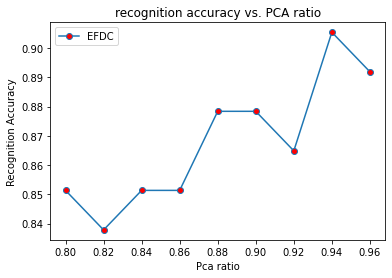

In [47]:
num_train = 6  ## Paper use 6 image per person for training in this expriment
img_vectors, labels = img2vec('yalefaces')
train_data, test_data, train_labels, test_labels = split_train_test(img_vectors, labels, num_train)
adj_graph = get_adj_graph(train_data, train_labels)
S_w, S_b, S_d = get_scatter_matrixes(train_data, train_labels, adj_graph)

acc_per_pca_ration = {}
for i in range(9):
    PCA_ratio = 0.8 + i*0.02
    decomposed_img_vecs, decomposed_S_w, decomposed_S_b, decomposed_S_d, W_pca = decompose_scatter_matrixes(train_data, S_w, S_b, S_d, PCA_ratio)
    W_E = get_generalized_eigens(decomposed_S_w, decomposed_S_b, decomposed_S_d, 0.9, 12)
    projected_train_vectors = project_data(train_data.T, W_pca, W_E)
    classifier = get_classifier(projected_train_vectors, train_labels)
    accuracy = evaluate(classifier, test_data, test_labels, W_pca, W_E)
    acc_per_pca_ration[PCA_ratio] = accuracy
plot_acc_per_dim(acc_per_pca_ration, 'Pca ratio', 'Recognition Accuracy', 'recognition accuracy vs. PCA ratio')

#### Show time of approache over tesing images

In [48]:
num_train = 6  ## Paper use 6 image per person for training in this expriment
img_vectors, labels = img2vec('yalefaces')
train_data, test_data, train_labels, test_labels = split_train_test(img_vectors, labels, num_train)
adj_graph = get_adj_graph(train_data, train_labels)
S_w, S_b, S_d = get_scatter_matrixes(train_data, train_labels, adj_graph)

decomposed_img_vecs, decomposed_S_w, decomposed_S_b, decomposed_S_d, W_pca = decompose_scatter_matrixes(train_data, S_w, S_b, S_d, 0.96)
W_E = get_generalized_eigens(decomposed_S_w, decomposed_S_b, decomposed_S_d, 0.9, 14)
projected_train_vectors = project_data(train_data.T, W_pca, W_E)
classifier = get_classifier(projected_train_vectors, train_labels)
start_time = time.time()
accuracy = evaluate(classifier, test_data, test_labels, W_pca, W_E)
end_time = time.time()
print("time of testing: {:.4f} s".format(end_time - start_time))

time of testing: 0.0206 s
